# Epymorph dev log: May 31, 2023

Author: Alexander Nez

as of git hash:

### Social Determinate of Health (sdh)

### sdh toml params
theta = 0.1 

move_control = 0.9

infection_duration = 4.0

immunity_duration = 90.0

infection_seed_loc = 0

infection_seed_size = 100

hospitalization_duration = 14.0

alpha = [0.1, 0.3, 0.2]



# sdh with pei movement

### plots sdh model by prevalence
python -m epymorph run --ipm sdh --mm centroids --geo maricopa_cbg_2019 --params "./scratch/params/sdh_params.toml" --start_date "2015-01-01" --duration "150d" --chart "p0" --out ./scratch/output_files/sdh.csv 
### creates sirh_sdh
python -m epymorph run --ipm sdh --mm icecube --geo maricopa_cbg_2019 --params ./scratch/params/sdh_params.toml --start_date 2015-01-01 --duration 150d --out ./scratch/output_files/sdh.csv 

In [10]:
from epymorph.run import run
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.simulation import Simulation
from epymorph.world import Population 

from shapely.geometry import Point, Polygon
from matplotlib.pyplot import xlabel
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import pandas as pd
import numpy as np
import os

dir = os.path.expanduser('~/Desktop/Github/Epymorph/scratch')
with np.load(f"./epymorph/data/geo/maricopa_cbg_2019_geo.npz") as npz_data:
        data = dict(npz_data)
geo = 'https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/04_ARIZONA/04013/tl_2020_04013_bg10.zip'

maricopa = gpd.read_file(geo)


In [13]:
exit_code = run(
    ipm_name = 'sdh',
    mm_name = 'centroids',
    geo_name = 'maricopa_cbg_2019',
    start_date_str = '2015-01-01',
    duration_str = '150d',
    params_path = f"{dir}/params/sdh_params.toml",
    out_path = None,
    chart = 'p0',
    profiling=False
)

Loading requirements:
[✓] IPM (sdh)
[✓] MM (icecube)
[✓] Geo (maricopa_cbg_2019)
[✓] Parameters (file:/Users/alexandernez/Desktop/Github/Epymorph/scratch/params/sdh_params.toml)

Running simulation:
• 2015-01-01 to 2015-05-31 (150 days)
• 2505 geo nodes


ValueError: colors must be a one-dimensional sequence of nonnegative integers not exceeding 9223372036854775807.

# Formatting the sdh.csv to be more readable
np.exp(g0 * (((g1 * scale_h1) + (g2 * scale_h2))) / (1 + np.exp(((g1 *scale_h1) + (g2 * scale_h2)))))

In [15]:
header_names = ['days', 'tracts', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']
df = pd.read_csv(dir + '/output_files/sdh.csv', header= None, skiprows = 1, names = header_names)
df['I & H->R'] = df['I->R'] + df['H->R']
df.groupby(['days']).sum().drop(labels= 'tracts', axis='columns').sort_index().to_csv(dir + '/output_files/sdh_sort.csv')


In [11]:
geo_df = pd.DataFrame({k: list(v) for k, v in data.items()})
lat_lon_df = pd.DataFrame(geo_df["centroid"].to_list(), columns=['Lat', 'Lon'])
data = [geo_df,lat_lon_df]
geo_df = pd.concat(data, axis =1)

print(geo_df.head())

         labels  population                               centroid  \
0  040130101011        1791  [-111.770772219983, 33.7692433720249]   
1  040130101012        2007   [-111.720000642927, 33.741096326025]   
2  040130101013        1264  [-111.666997365524, 33.7239868229889]   
3  040130101021        1139   [-111.490977560506, 33.715337047738]   
4  040130101022        1487  [-111.850574119318, 33.8260427149521]   

   median_age                     pop_by_age  median_income  total_income  \
0        50.5  [358, 110, 671, 374, 194, 84]          99219      90125800   
1        63.9   [162, 0, 423, 460, 559, 403]         127614     155213500   
2        70.8      [0, 22, 0, 249, 655, 338]          80742      73694600   
3        58.9    [58, 52, 361, 362, 258, 48]         105987      89511200   
4        62.8  [110, 82, 202, 500, 452, 141]         128523     128439900   

   average_household_size  pop_density_km2  tract_gini_index         Lat  \
0                    2.33        99.3017

In [12]:

#print(df[df.eq("040130715151").any(axis=1)])
geo_df['gamma'] = 0 
geo_df['gamma 0'] = 0

geo_df['beta'] = 0
geo_df['alpha 0'] = 0.1
geo_df["alpha 1"] = 0.8
geo_df["alpha 2"] = 0.2    

for i in range(len(geo_df)):
    # Alpha values used to control beta
    a0 = geo_df['alpha 0'][i]
    a1 = geo_df['alpha 1'][i]
    a2 = geo_df['alpha 2'][i]

    # Social Determinate of Health (SDH) values for beta
    x1 = geo_df["average_household_size"][i]
    x2 = geo_df["pop_density_km2"][i]
    
    # Social Determinate of Health (SDH) values for gamma
    h1 = geo_df["median_income"][i]
    h2 = geo_df["tract_gini_index"][i]

    # Scaling function used to calculate beta and gamma 
    scale_x1 = (x1 - geo_df["average_household_size"].mean()) / geo_df["average_household_size"].std()
    scale_x2 = (x2 - geo_df["pop_density_km2"].mean()) / geo_df["pop_density_km2"].std()
    scale_h1 = (h1 - geo_df["median_income"].mean()) / geo_df["median_income"].std()
    scale_h2 = (h2 - geo_df["tract_gini_index"].mean()) / geo_df["tract_gini_index"].std()
    
    # Calculate gamma based on Alpha values used to control gamma
    g0 = geo_df["gamma 0"][i]
    for x in np.arange(0.01, 0.03, 0.001):
        median_income = geo_df.sort_values(by= 'median_income')              
        gini_index = geo_df.sort_values(by= 'tract_gini_index')
        g0 = 0.00290022
        geo_df.loc[i, 'gamma 0'] = g0

    # Calculate the value of beta and gramma for each nodes
    beta = np.exp((a0 + (a1 * scale_x1) * (a2 * scale_x2)))
    gamma = g0 * (np.exp(-(scale_h1 + scale_h2)) / (1 + np.exp(-(scale_h1 + scale_h2))))

    # Saved the calculate value of beta and gamma in its respected node index
    geo_df.loc[i, ['beta', 'gamma']] = [beta, gamma]
geo_df.to_csv(dir + '/utility/geo.csv')

### plotting result

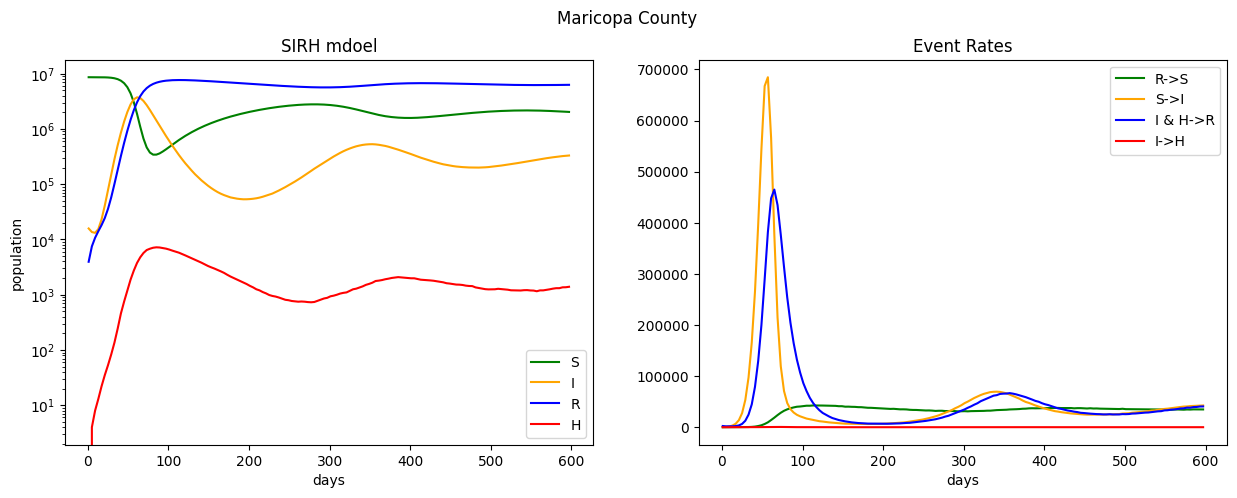

In [16]:
sdh = pd.read_csv(dir + '/output_files/sdh_sort.csv')
                 
# Get current axis
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
fig.suptitle('Maricopa County')
sirh = ['S', 'I', 'R', 'H']
sirh_name = ['Susceptible', 'Infected', 'Recovered', 'hospitalized']
event_rate = ['R->S', 'S->I', 'I & H->R', 'I->H' ]
color = ['green', 'orange', 'blue', 'red']

Events = sdh[['days', 'S->I', 'I->R', 'I->H','H->R', 'R->S', 'I & H->R']]
sirh_compartment = sdh[['days', 'S', 'I', 'R', 'H']]
sirh_compartment = sirh_compartment.groupby(sirh_compartment['days'] // 2, sort=False).sum()
Events = Events.groupby(Events['days'] // 2, sort=False).sum()
# Plots sirh model
for i in range(4):
    sirh_compartment.plot(kind='line',
            x='days',
            y= sirh[i],
            ylabel="population", 
            logy=True,
            color=color[i], 
            ax=axes[0],
            title = 'SIRH mdoel') 
    Events.plot(kind='line', 
            x='days',
            y=event_rate[i],
            color=color[i], 
            ax=axes[1],
            title = 'Event Rates')    
# show the plot
plt.show()



In [24]:
# designate coordinate system

# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(geo_df['centroid'[i][j]], geo_df['centroid'])]
# create GeoPandas dataframe
gpd_df = gpd.GeoDataFrame(df,
 geometry = geometry)

ValueError: Point() takes only scalar or 1-size vector arguments, got ((array([-111.77077222,   33.76924337]), array([-111.77077222,   33.76924337])),)

In [19]:
maricopa


,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,04,013,010101,1,040130101011,Block Group 1,G5030,S,18032212,3588,+33.7694934,-111.7709334,"POLYGON ((-111.78699 33.79047, -111.78698 33.7..."
1,04,013,010101,2,040130101012,Block Group 2,G5030,S,29348154,9045,+33.7405709,-111.7196069,"POLYGON ((-111.78692 33.73773, -111.78692 33.7..."
2,04,013,010101,3,040130101013,Block Group 3,G5030,S,6873642,14833,+33.7230978,-111.6664268,"POLYGON ((-111.68352 33.72266, -111.68352 33.7..."
3,04,013,010102,1,040130101021,Block Group 1,G5030,S,2369337823,32000577,+33.7127644,-111.4789010,"POLYGON ((-111.88205 34.00478, -111.88203 34.0..."
4,04,013,010102,3,040130101023,Block Group 3,G5030,S,326640669,37849,+33.9337779,-111.9020760,"POLYGON ((-112.06540 33.93122, -112.06538 33.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,04,013,980700,1,040139807001,Block Group 1,G5030,S,84870187,29618,+33.6921146,-111.7598427,"POLYGON ((-111.78751 33.69810, -111.78720 33.6..."
2501,04,013,980100,1,040139801001,Block Group 1,G5030,S,2912819033,6913,+32.7253646,-112.9041112,"POLYGON ((-113.33389 32.50558, -113.33387 32.5..."
2502,04,013,817300,3,040138173003,Block Group 3,G5030,S,1718650,0,+33.2266825,-111.8647011,"POLYGON ((-111.87640 33.23267, -111.87604 33.2..."
2503,04,013,817500,2,040138175002,Block Group 2,G5030,S,1302398,0,+33.2107935,-111.8626864,"POLYGON ((-111.86757 33.20429, -111.86716 33.2..."


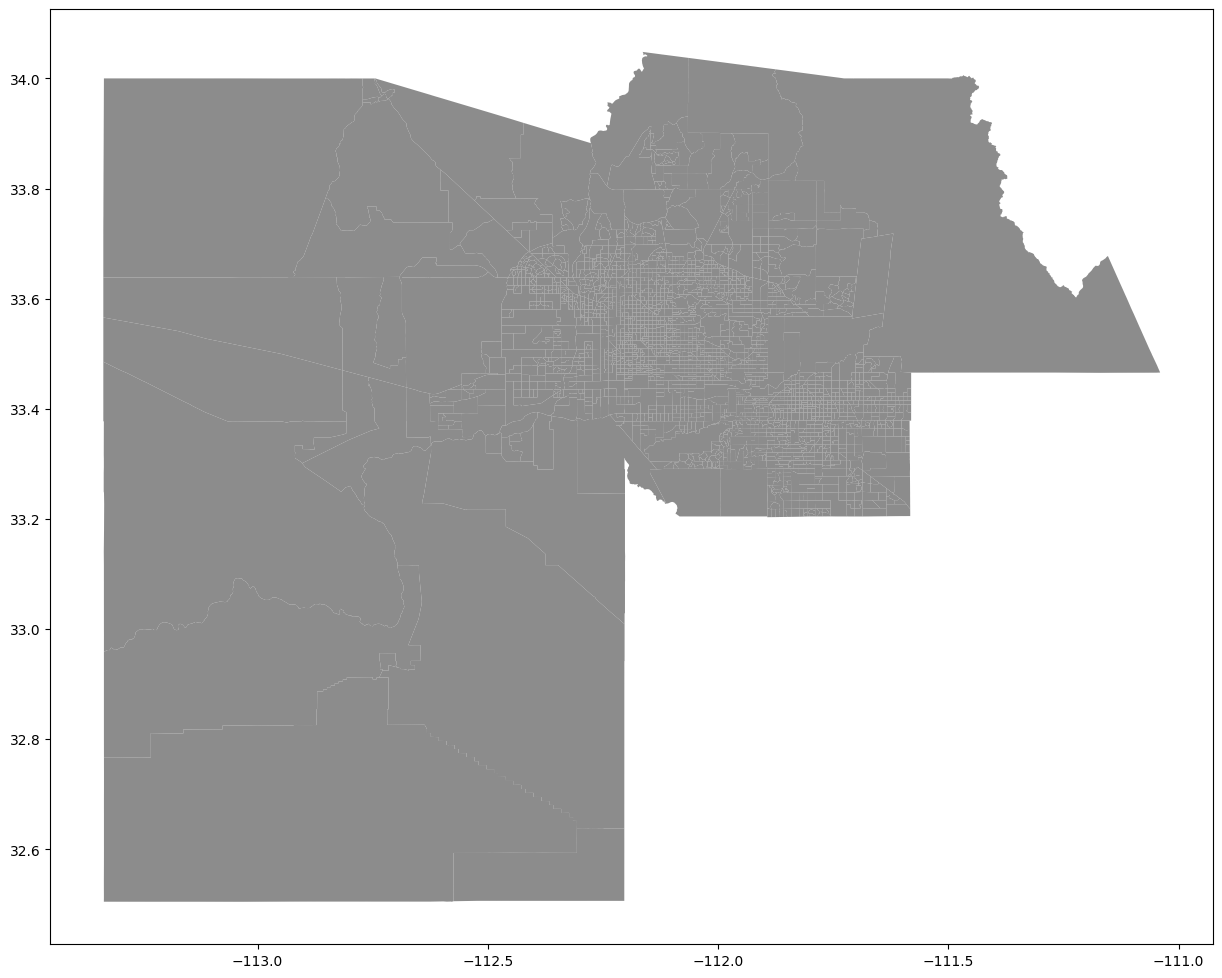

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
maricopa.plot(ax=ax, alpha=0.9,color= 'grey')
#maricopa.plot(column= 'S', ax=ax,alpha=0.5, legend=True,markersize=10)

plt.show()


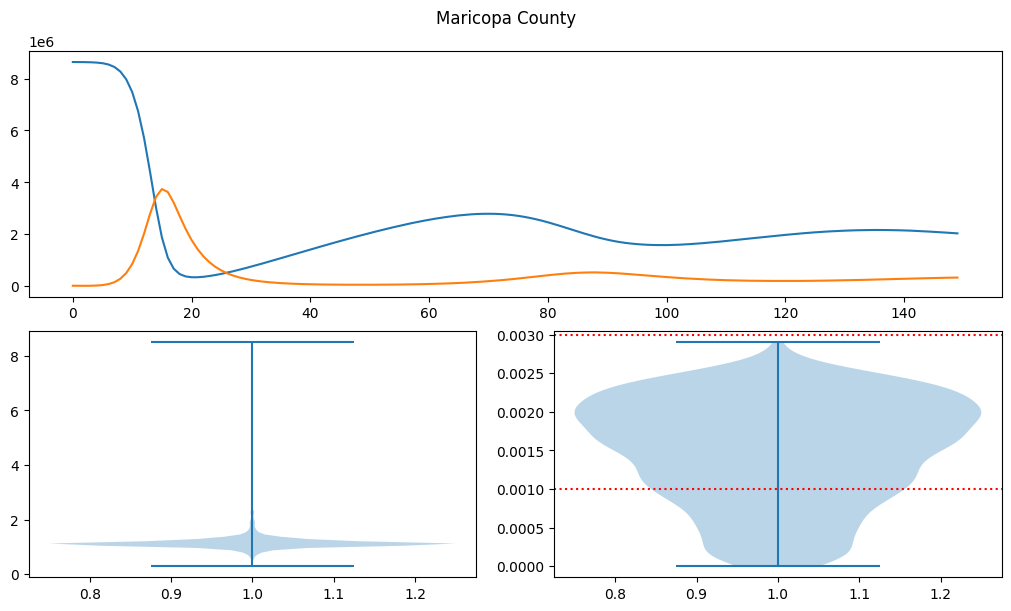

In [17]:
fig = plt.figure(figsize=(10,6), layout="constrained")
spec = fig.add_gridspec(2, 2)
fig.suptitle('Maricopa County')

ax0 = fig.add_subplot(spec[0, :])
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])

ax0.plot(sirh_compartment['S'])
ax0.plot(sirh_compartment['I'])
ax10.violinplot(geo_df['beta'])
ax11.violinplot(geo_df['gamma'])
plt.axhline(y = 0.001, color = 'r', linestyle = 'dotted')
plt.axhline(y = 0.003, color = 'r', linestyle = 'dotted')

plt.show()
